In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.7 MB/s eta 0:00:00


In [ ]:
# Tiny dataset
# !gdown https://drive.google.com/uc?id=1qYPCnXXxjEcHEg3tLGt3fDkd2ialAgS4
import os
# Full dataset with jpeg
!gdown https://drive.google.com/uc?id=1-xJoBvzwQKgJjPzHb3fq1sFicwyIisx7

# Full dataset without jpeg
# https://drive.google.com/file/d/1gFSdm8K9SXNPXG9tQWS4bmO_nappN2AL/view?usp=share_link
# !gdown https://drive.google.com/uc?id=1gFSdm8K9SXNPXG9tQWS4bmO_nappN2AL
!unzip data_v1.zip -d /content/data
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Downloading...
From: https://drive.google.com/uc?id=1-xJoBvzwQKgJjPzHb3fq1sFicwyIisx7
To: /content/data_v1.zip
100% 640M/640M [00:05<00:00, 121MB/s]
Archive:  data_v1.zip
   creating: /content/data/train-images/
  inflating: /content/data/train-images/00000000002.jpg  
  inflating: /content/data/train-images/00000000003.jpg  
  inflating: /content/data/train-images/00000000004.jpg  
  inflating: /content/data/train-images/00000000005.jpg  
  inflating: /content/data/train-images/00000000006.jpg  
  inflating: /content/data/train-images/00000000009.jpg  
  inflating: /content/data/train-images/00000000010.jpg  
  inflating: /content/data/train-images/00000000017.jpg  
  inflating: /content/data/train-images/00000000020.jpg  
  inflating: /content/data/train-images/00000000022.jpg  
  inflating: /content/data/train-images/00000000023.jpg  
  inflating: /content/data/train-images/00000000025.jpg  
  inflating: /content/data/train-images/00000000026.jpg  
  inflating: /content/data/train-i

In [ ]:
%cd /content/data
import json
data = json.load(open("train_data.json", "r"))

/content/data


In [ ]:
data['annotations'][0]

{'id': 0,
 'image_id': 2,
 'caption': 'ba chiếc thuyền đang di chuyển ở trên con sông',
 'segment_caption': 'ba chiếc thuyền đang di_chuyển ở trên con sông'}

# Vocab

In [ ]:
from collections import Counter
import itertools
from itertools import count

class IMCP_Vocab():
  def __init__(self, texts) -> None:
    words = list(itertools.chain(*[text.split(" ") for text in texts]))
    counter = Counter(words)
    self.vocab = {key: i for i, key in zip(count(start = 5), counter.keys())}

    self.special_ids = [0, 1, 2, 3]
    self.max_seq_len = 256
    self.special_tokens = ["<s>", "</s>", "<pad>", "<unk>"]
    for id, token in zip(self.special_ids, self.special_tokens):
      self.vocab[token] = id
    self.vocab = {k: v for k, v in sorted(self.vocab.items(), key=lambda x:x[1])}
    self.id2word = {v: k for k, v in self.vocab.items()}
    
    self.bos_token = "<s>"
    self.eos_token = "</s>"
    self.pad_token = "<pad>"
    self.unk_token = "<unk>"
    
  def get_vocab(self):
    return self.vocab
  
  def batch_decode(self, predictions_ids):
    preds = []
    for seq in predictions_ids:
        preds.append(" ".join([self.id2word[id] for id in seq if id not in [0,1,2,3,4,5]]))
    return preds

# Dataset

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import json
import os

class IMCP_Dataset(Dataset):
  def __init__(self, image_path = "train-images", summary_path = "train_data.json"):
    super().__init__()
    self.data = json.load(open(summary_path, "r"))
    self.image_path = image_path
    self.vocab = IMCP_Vocab(texts = [ann['segment_caption'] for ann in self.data['annotations']])
    self.imgid2imgname = {entry['id']: entry['filename'] for entry in self.data['images']}

  def __len__(self):
    return len(self.data['annotations'])

  def __getitem__(self, index):
    annotation = self.data['annotations'][index]
    image_id = annotation['image_id']
    # images = self.data['images'][index]
    # image_id = images['id']
    image_name = self.imgid2imgname[image_id]
    image = Image.open(os.path.join(self.image_path, image_name)).convert('RGB')
    caption = annotation['segment_caption']
    return image, caption

In [ ]:
class IMCP_Test_Dataset(Dataset):
  def __init__(self, image_path = "public-test-images", summary_path = "test_data.json"):
    super().__init__()
    self.data = json.load(open(summary_path, "r"))
    self.image_path = image_path
    self.imgid2imgname = {entry['id']: entry['filename'] for entry in self.data['images']}

  def __len__(self):
    return len(self.data['images'])

  def __getitem__(self, index):
    entry = self.data['images'][index]
    image_id = entry['id']
    image_name = entry['filename']
    image = Image.open(os.path.join(self.image_path, image_name)).convert('RGB')
    caption = [self.data['annotations'][i]['segment_caption'] for i in range(len(self.data['annotations'])) if self.data['annotations'][i]['image_id'] == image_id]
    return image, caption

In [ ]:
train_dataset = IMCP_Dataset()
test_dataset = IMCP_Test_Dataset()
vocab = train_dataset.vocab

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

# Collator

In [ ]:
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms

class IMCP_Collator:
  def __init__(self, vocab, train = True, model = "vit"):
    self.vocab = vocab
    self.bos_id = self.vocab.get_vocab()['<s>']
    self.eos_id = self.vocab.get_vocab()['</s>']
    self.pad_id = self.vocab.get_vocab()['<pad>']
    self.model = model
    self.train = train

  def tokenize_texts(self, captions):
    raw_captions = [caption.split(" ") for caption in captions]
    truncated_captions = [s[:self.vocab.max_seq_len] for s in raw_captions]
    max_len = max([len(c) for c in truncated_captions])

    padded_captions = []
    for c in truncated_captions:
        c = [self.vocab.get_vocab()[word] for word in c]
        seq = [self.bos_id] + c + [self.eos_id] + [self.pad_id] * (max_len - len(c))
        padded_captions.append(seq)

    padded_captions = [torch.Tensor(seq).long() for seq in padded_captions]
    padded_captions = pad_sequence(padded_captions, batch_first=True)
    return padded_captions
  
  def resize_and_stack(self, images):
    if self.model == "vit":
      image_tensors = []
      transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
      ])
      
      for image in images:
        img_tensor = transform(image)
        image.close()
        image_tensors.append(img_tensor)
        
      stacked = torch.stack(image_tensors)
      return stacked
    else:
      pass

  def __call__(self, batch):
    if self.train:
      images = [example[0] for example in batch]
      captions = [example[1] for example in batch]
      return self.resize_and_stack(images), self.tokenize_texts(captions)
    else:
      images = [example[0] for example in batch]
      captions = [example[1] for example in batch]
      return self.resize_and_stack(images), captions
    

In [ ]:
collator = IMCP_Collator(vocab, train = True, model = "vit")
collatorTest = IMCP_Collator(vocab, train = False, model = "vit")

# DataLoader

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 16, collate_fn = collator)
test_dataloader = DataLoader(test_dataset, batch_size = 16, collate_fn = collatorTest)

In [ ]:
for images, captions in train_dataloader:
  print(images.shape)
  print(captions)
  break

torch.Size([16, 3, 224, 224])
tensor([[ 0,  5,  6,  7,  8,  9, 10, 11, 12, 13,  1,  2,  2],
        [ 0, 14,  5, 12,  7,  8,  9, 11, 12, 13,  1,  2,  2],
        [ 0, 11, 15, 13, 14,  5, 12,  7,  8,  9,  1,  2,  2],
        [ 0,  5, 12,  7,  8,  9, 16, 17, 18, 19, 20,  1,  2],
        [ 0,  5,  6,  7,  8, 21, 11, 17, 12, 13,  1,  2,  2],
        [ 0, 22, 23,  8, 24, 17, 25, 26, 11, 27,  1,  2,  2],
        [ 0, 10, 11, 27, 22, 23, 14, 17, 25, 26,  1,  2,  2],
        [ 0, 22, 23, 24, 17, 25, 28, 10, 11, 27,  1,  2,  2],
        [ 0, 14, 17, 25, 28, 11, 27, 29, 22, 23,  1,  2,  2],
        [ 0, 14, 17, 25, 26, 10, 11, 27, 29, 17, 22, 23,  1],
        [ 0, 22, 23,  8, 30, 31, 32,  6, 33,  1,  2,  2,  2],
        [ 0, 14, 34,  6, 33, 35, 36, 22, 23,  1,  2,  2,  2],
        [ 0, 14, 17, 22, 23, 37, 32,  6, 33,  1,  2,  2,  2],
        [ 0, 32,  6, 33,  8, 38, 39, 29, 22, 23,  1,  2,  2],
        [ 0, 22, 23,  8, 40, 32,  6, 33, 10, 35, 36,  1,  2],
        [ 0, 14, 34, 22,  8, 41, 10, 42,

# Model

In [ ]:
config = {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "MBartModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 2,
  "decoder_start_token_id": 1,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 2,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": False,
  "init_std": 0.02,
  "is_encoder_decoder": True,
  "max_position_embeddings": 256,
  "model_type": "mbart",
  "num_hidden_layers": 2,
  "pad_token_id": 2,
  "scale_embedding": False,
  "torch_dtype": "float32",
  "transformers_version": "4.10.2",
  "use_cache": True,
  "vocab_size": len(collator.vocab.get_vocab()) + 5
}

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn.utils.rnn import pack_padded_sequence

from transformers import ViTModel
from transformers import BartForConditionalGeneration, BartConfig

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Vision Transformer encoder
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.linear = nn.Linear(self.vit.config.hidden_size, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, images):
        with torch.no_grad():
            features = self.vit(images)
        features = self.linear(features.last_hidden_state)
        features = self.relu(features)
        features = self.dropout(features)
        return features

# Define Transformer decoder
class Decoder(nn.Module):
    def __init__(self, max_seq_length):
        super(Decoder, self).__init__()
        self.config = BartConfig(**config)
        self.decoder = BartForConditionalGeneration(self.config)
        self.max_seq_length = max_seq_length
    
    def forward(self, features, captions):
        outputs = self.decoder(
            encoder_outputs = [features], ## Use [] instead of () Important!
            labels = captions)
        return outputs

    def generate(self, features, max_length = 50):
        model_kwargs = {
            "encoder_outputs": [features], ## Use [] instead of () Important!
        }
        input_ids = torch.ones((len(features), 1), device=device, dtype=torch.long)
        input_ids = input_ids * 1
        output = self.decoder.generate(input_ids, num_beams=1, max_new_tokens = max_length, **model_kwargs)
        return output


# Define hyperparameters
vocab_size = len(collator.vocab.get_vocab()) + 5
embed_size = 512
max_seq_length = 30
learning_rate = 0.0001
num_epochs = 2

# Initialize encoder and decoder
encoder = Encoder(embed_size).to(device)
decoder = Decoder(max_seq_length).to(device)

# Define loss function and optimizer
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = Adam(params, lr=learning_rate)

# Train the model
# for epoch in range(num_epochs):
#     print(f"Start Epoch {epoch}")
#     for i, (images, captions) in enumerate(train_dataloader):
#         # Move data to GPU
#         images = images.to(device)
#         captions = captions.to(device)
        
#         # Forward pass
#         features = encoder(images)
#         outputs = decoder(features, captions)
#         loss = outputs.loss
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         # Print loss
#         if i % 100 == 0:
#             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_dataloader), loss.item()))

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# torch.save(encoder.state_dict(), 'viit/encoder.pth')
# torch.save(decoder.state_dict(), 'viit/decoder.pth')

# Inference

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
encoder.load_state_dict(torch.load('/content/drive/MyDrive/Lab/checkpoints/vittrans/encoder.pth'))
decoder.load_state_dict(torch.load('/content/drive/MyDrive/Lab/checkpoints/vittrans/decoder.pth'))

<All keys matched successfully>

In [ ]:
my_preds = []
targets = []
for i, (images, captions) in enumerate(test_dataloader):
    # Move data to GPU
    images = images.to(device)
    # Forward pass
    features = encoder(images)
    out = decoder.generate(features)
    preds = out.detach().cpu().numpy()
    my_preds.extend(vocab.batch_decode(preds))
    targets.extend(captions)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
score = corpus_bleu(targets, my_preds)
print(f"BLEU SCORE VITTRANS: {score}")

BLEU SCORE VITTRANS: 0.6729888658411532


In [ ]:
import matplotlib.pyplot as plt

def image_captioning(image_name: str):
    image = Image.open(image_name).convert('RGB')
    plt.imshow(image)
    images = collator.resize_and_stack([image])
    images = images.to(device)
    features = encoder(images)
    out = decoder.generate(features)
    preds = out.detach().cpu().numpy()
    plt.title(vocab.batch_decode(preds)[0])
    plt.show()

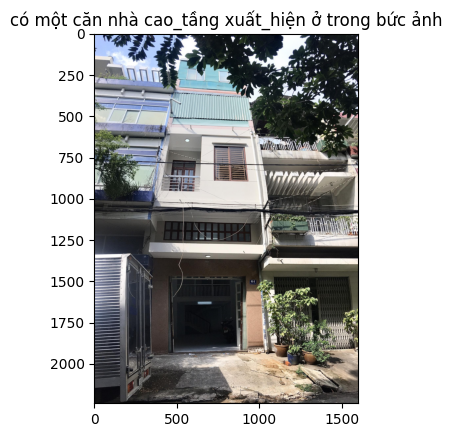

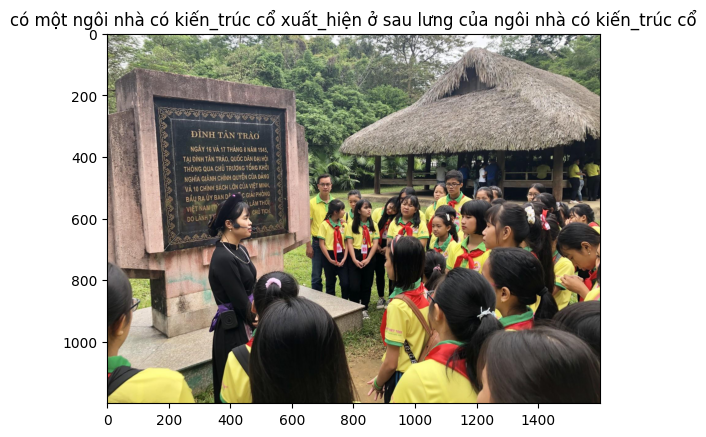

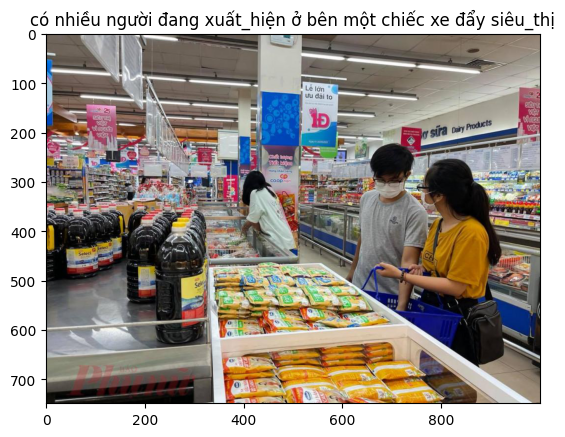

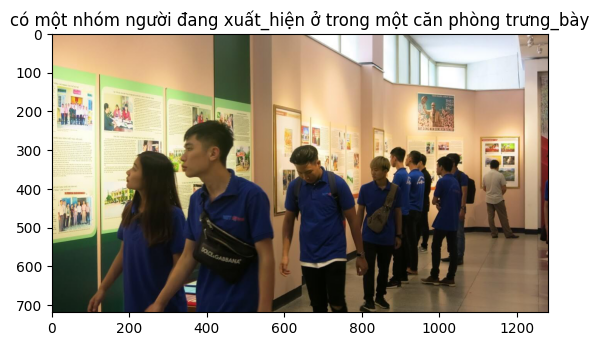

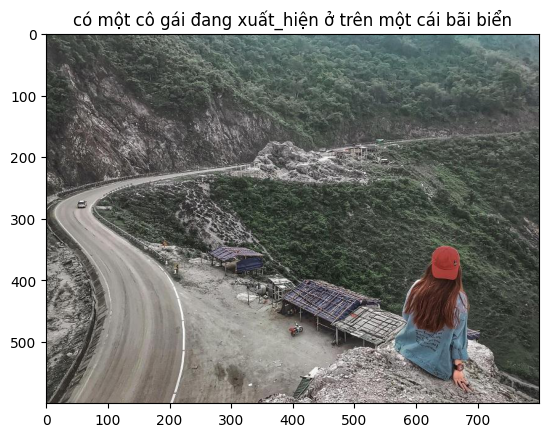

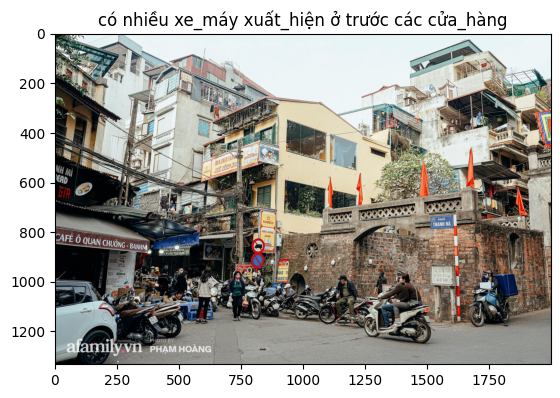

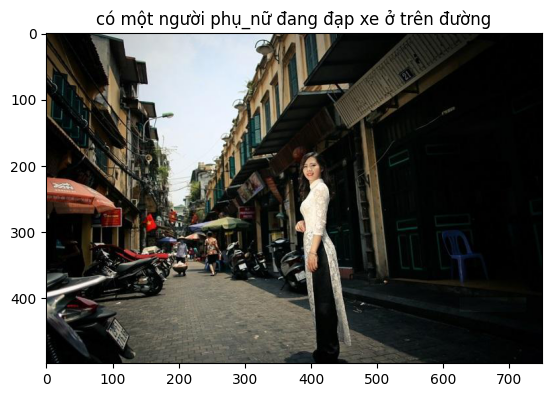

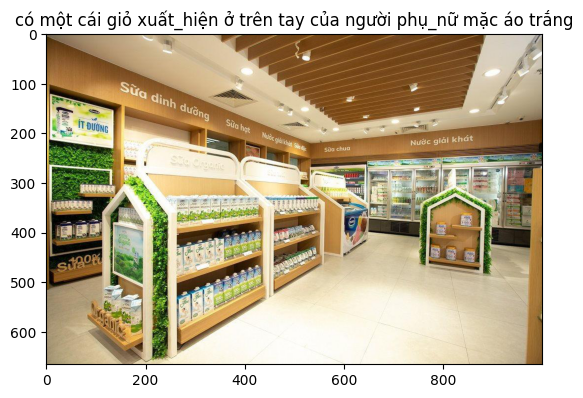

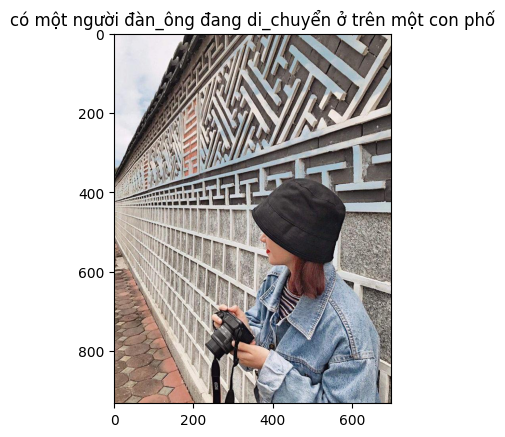

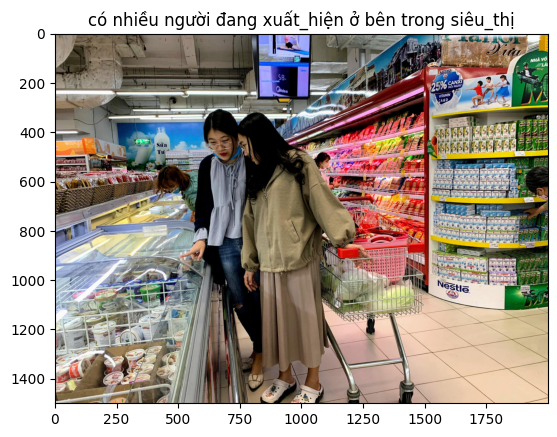

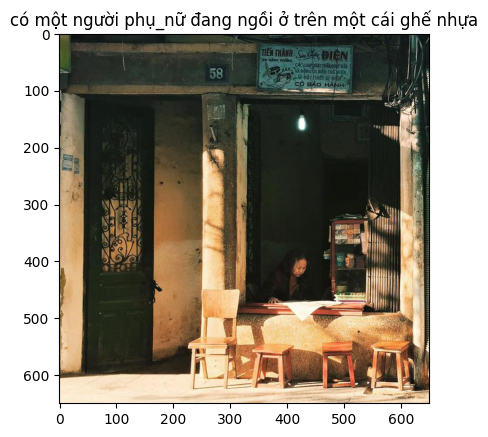

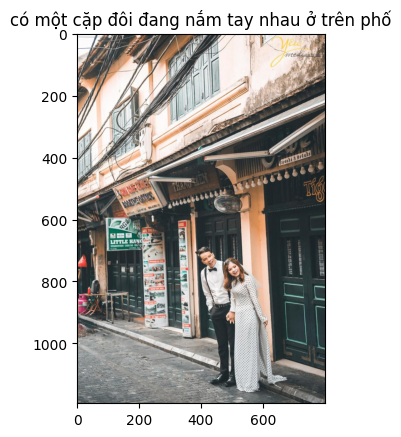

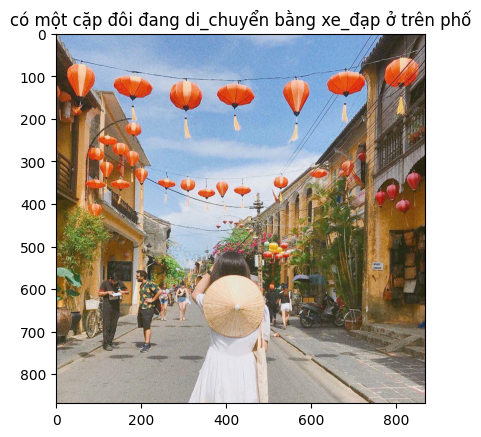

In [ ]:
image_captioning("public-test-images/00000000001.jpg")
image_captioning("public-test-images/00000000078.jpg")
image_captioning("public-test-images/00000000115.jpg")
image_captioning("public-test-images/00000000118.jpg")
image_captioning("public-test-images/00000000190.jpg")
image_captioning("public-test-images/00000000322.jpg")
image_captioning("public-test-images/00000000331.jpg")
image_captioning("public-test-images/00000000363.jpg")
image_captioning("public-test-images/00000000490.jpg")
image_captioning("public-test-images/00000000657.jpg")
image_captioning("public-test-images/00000000702.jpg")
image_captioning("public-test-images/00000000834.jpg")
image_captioning("public-test-images/00000001052.jpg")
image_captioning("public-test-images/00000001109.jpg")
image_captioning("public-test-images/00000009770.jpg")
image_captioning("public-test-images/00000011015.jpeg")